<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#D.-Systematische-Handelsstrategien" data-toc-modified-id="D.-Systematische-Handelsstrategien-1">D. Systematische Handelsstrategien</a></span></li><li><span><a href="#D.1-Ein-Asset-Strategien" data-toc-modified-id="D.1-Ein-Asset-Strategien-2">D.1 Ein-Asset-Strategien</a></span></li><li><span><a href="#D.1.2-Momentum-Strategien" data-toc-modified-id="D.1.2-Momentum-Strategien-3">D.1.2 Momentum-Strategien</a></span><ul class="toc-item"><li><span><a href="#3.-Moving-Average-Crossover:-Performancemessung" data-toc-modified-id="3.-Moving-Average-Crossover:-Performancemessung-3.1">3. Moving Average Crossover: Performancemessung</a></span></li></ul></li></ul></div>

# D. Systematische Handelsstrategien
# D.1 Ein-Asset-Strategien
# D.1.2 Momentum-Strategien

## 3. Moving Average Crossover: Performancemessung
In diesem Abschnitt machen wir uns die Ergebnisse zunutze, die wir im letzten Abschnitt aus dem Backtest zur Crossover-Strategie mit gleitenden Durchschnitten erhalten haben. Zudem verbringen wir etwas Zeit damit, die sogenannte Equity Curve einzuführen und tiefer in die Analyse einiger wichtiger Leistungsindikatoren einzusteigen.

In [1]:
#import relevant modules
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from math import sqrt
import matplotlib.pyplot as plt

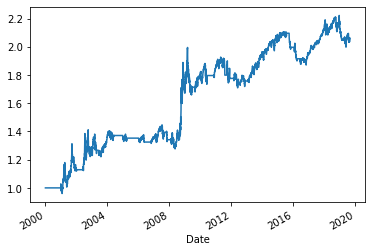

In [2]:
#download data into DataFrame and create moving averages columns
sp500 = web.get_data_yahoo('^GSPC',start='1/1/2000',end='8/31/2019')

sp500['42d'] = np.round(sp500['Close'].rolling(window=42).mean(),2)
sp500['252d'] = np.round(sp500['Close'].rolling(window=252).mean(),2)

#create column with moving average spread differential
sp500['42-252'] = sp500['42d'] - sp500['252d']

#set desired number of points as threshold for spread difference and 
#create column containing strategy 'Stance'
X = 50
sp500['Stance'] = np.where(sp500['42-252'] > X, 1, 0)
sp500['Stance'] = np.where(sp500['42-252'] < -X, -1, sp500['Stance'])
sp500['Stance'].value_counts()

#create columns containing daily market log returns and strategy daily log returns
sp500['Market Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['Strategy'] = sp500['Market Returns'] * sp500['Stance'].shift(1)

#set strategy starting equity to 1 (i.e. 100%) and generate equity curve
sp500['Strategy Equity'] = sp500['Strategy'].cumsum() + 1

#show chart of equity curve
sp500['Strategy Equity'].plot();


Beachten Sie, dass die Equity Curve einer Strategie die kumulierten Strategierenditen (um 1 erhöht) darstellt. Sie steht im DataFrame in der Spalte 'Strategy Equity'. 

Zur Struktur der nachfolgenden Inhalte: wir beginnen mit Diagrammen und besprechen dann zentrale Performancemaße.

1) Abschnitt "Diagramme" - wir werden zunächst nützliche Diagramme zur Performanceanalyse einer Strategie erstellen:

    a) Gleitende 1-Jahres annualisierte Volatilität
    b) Gleitende 1-Jahres Trefferquote (Hit Ratio)
    c) Gleitende 1-Jahres-Renditen
    d) Tägliche Renditecharts
    e) Histogramm der täglichen Renditeverteilung

Unser erster Schritt besteht darin, ein neues DataFrame zu erstellen, das genau die Daten enthält, die wir benötigen, nämlich die Equity Curve der Strategie sowie die täglichen Strategierenditen. Dies geschieht wie folgt:

In [3]:
strat = pd.DataFrame([sp500['Strategy Equity'], sp500['Strategy']]).T

Jetzt müssen wir den DataFrame so aufbauen, dass er alle Rohdaten enthält, die wir für die Berechnung der oben skizzierten Datenreihen, die wir plotten wollen, benötigen. Der Code hierfür lautet:

In [4]:
#create columns that indicate whether each days return was positive, 
#negative or flat.
strat['win'] = (np.where(strat['Strategy'] > 0, 1,0)) 
strat['loss'] = (np.where(strat['Strategy'] < 0, 1,0)) 
strat['scratch'] = (np.where(strat['Strategy'] == 0, 1,0)) 

#create columns with a cumulative sum of each of the columns created above 
strat['wincum'] = (np.where(strat['Strategy'] > 0, 1,0)).cumsum() 
strat['losscum'] = (np.where(strat['Strategy'] < 0, 1,0)).cumsum() 
strat['scratchcum'] = (np.where(strat['Strategy'] == 0, 1,0)).cumsum() 

#create a column that holds a running sum of trading days - 
#we will use this to create our percentages later 
strat['days'] = (strat['wincum'] + strat['losscum'] + strat['scratchcum']) 

#create columns that show the 252 day rolling sum of the 
#winning/losing/flat days 
strat['rollwin'] = strat['win'].rolling(window=252).sum() 
strat['rollloss'] = strat['loss'].rolling(window=252).sum() 
strat['rollscratch'] = strat['scratch'].rolling(window=252).sum() 

#create columns with hit ratio and loss ratio data 
strat['hitratio'] = strat['wincum'] / (strat['wincum']+strat['losscum']) 
strat['lossratio'] = 1 - strat['hitratio'] 

#create columns with rolling 252 day hit ratio and loss ratio data 
strat['rollhitratio'] = strat['hitratio'].rolling(window=252).mean() 
strat['rolllossratio'] = 1 - strat['rollhitratio'] 

#create column with rolling 12 month return 
strat['roll12mret'] = strat['Strategy'].rolling(window=252).sum() 

#create column with average win, average loss and average daily return data 
strat['averagewin'] = strat['Strategy'][(strat['Strategy'] > 0)].mean() 
strat['averageloss'] = strat['Strategy'][(strat['Strategy'] < 0)].mean() 
strat['averagedailyret'] = strat['Strategy'].mean() 

#create column with rolling 1 year daily standard deviation and 
#rolling 1 year annualised standard deviation
strat['roll12mstdev'] = strat['Strategy'].rolling(window=252).std() 
strat['roll12mannualisedvol'] = strat['roll12mstdev'] * sqrt(252)

Gut, jetzt haben wir alle unsere Daten vorbereitet, um die verschiedenen, oben erwähnten Diagramme zu erstellen.

Wir können dies wie folgt tun:

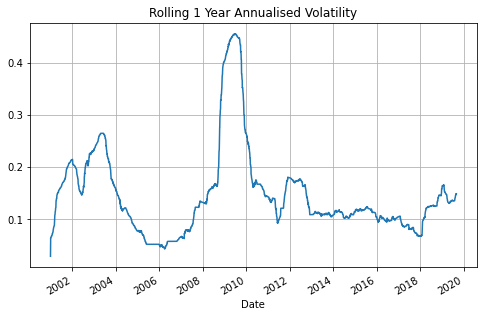

In [5]:
strat['roll12mannualisedvol'].plot(grid=True, figsize=(8,5),
title='Rolling 1 Year Annualised Volatility');

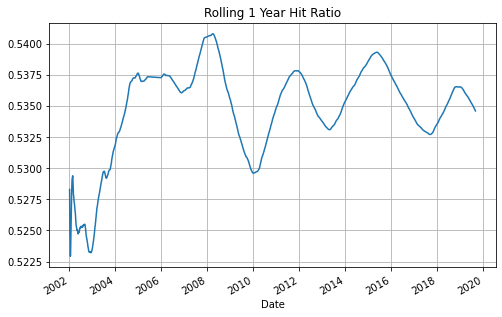

In [6]:
strat['rollhitratio'].plot(grid=True, figsize=(8,5),
title='Rolling 1 Year Hit Ratio');

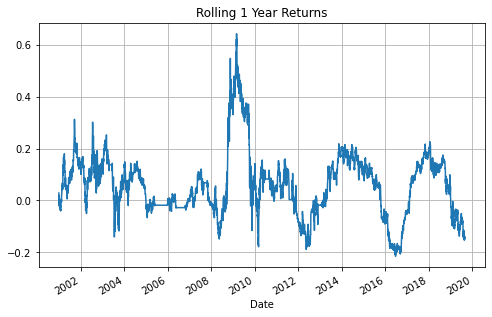

In [7]:
strat['roll12mret'].plot(grid=True, figsize=(8,5),
title='Rolling 1 Year Returns');

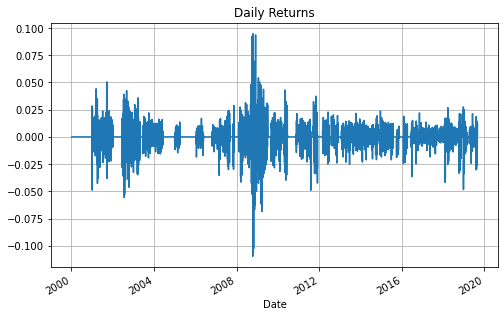

In [8]:
strat['Strategy'].plot(grid=True, figsize=(8,5),
title='Daily Returns');

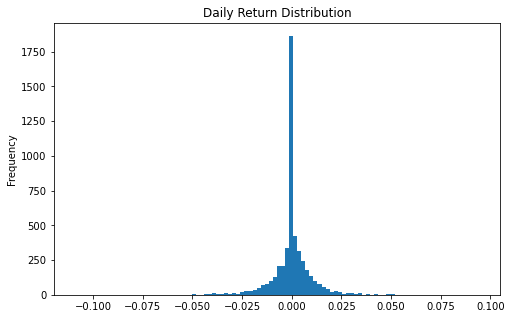

In [9]:
strat['Strategy'].plot(kind='hist',figsize=(8,5),
title='Daily Return Distribution',bins=100);

Als Randnotiz könnten wir hier schnell einen Blick auf die Schiefe (Skewness) und Wölbung (Kurtosis) der täglichen Renditeverteilung werfen, und zwar wie folgt

In [10]:
print("Skew:",round(strat['Strategy'].skew(),4))
print("Kurtosis:",round(strat['Strategy'].kurt(),4))

Skew: -0.0967
Kurtosis: 14.9604


Die Verteilung täglicher Strategierenditen ähnelt somit nicht einer Normalverteilung. Sie weist eine leicht negative Schiefe und eine hohe Kurtosis auf (die Schiefe der Normalverteilung ist 0 und die Kurtosis 3).

Wir werden jetzt einige wichtige Leistungsindikatoren (KPIs) erstellen, die in der Praxis regelmäßig zusammen mit der Analyse der Rendite von Handelsstrategien vorzufinden sind. Die Auswahl der Indikatoren erhebt dabei nicht den Anspruch vollständig zu sein.

Wir berechnen die folgenden KPIs:

    1) Annualisierte Rendite
    2) Rendite der letzten 12 Monate
    3) Volatilität
    4) Sharpe-Ratio
    5) Maximum Drawdown
    6) Calmar-Ratio (annualisierte Rendite / Maximum Drawdown)
    7) Volatilität / Maximum Drawdown
    8) Beste Monatsperformance
    9) Schlechteste Monatsperformance
    10) % gewinnbringender Monate & % der nicht gewinnbringenden Monate
    11) Anzahl der gewinnbringenden Monate/Anzahl der nicht gewinnbringenden Monate
    12) Durchschnittlicher monatlicher Gewinn
    13) Durchschnittlicher monatlicher Verlust
    14) Durchschnittlicher monatlicher Gewinn/durchschnittlicher monatlicher Verlust

Bevor wir weitermachen, werden wir noch schnell einen neuen DataFrame erstellen, der unsere Strategieergebnisse auf monatlicher statt auf täglicher Basis enthält - dies wird später bestimmte Berechnungen erleichtern und es uns ermöglichen, eine monatliche Ergebnistabelle zu erzeugen; das neue DataFrame kann durch "re-sampling" der ursprünglichen DataFrame-Spalte der täglichen Strategieergebnisse erstellt werden.

In [11]:
#Create a new DataFrame to hold our monthly data and populate it with 
#the data from the daily returns column of our original DataFrame 
#and sum it by month
stratm = pd.DataFrame(strat['Strategy'].resample('M').sum())

#Build the monthly data equity curve
stratm['Strategy Equity'] = stratm['Strategy'].cumsum()+1

#Add a column that holds the numerical monthly index 
#(i.e. Jan = 1, Feb = 2 etc)
stratm['month'] = stratm.index.month


Schauen wir uns einen Ausschnitt aus dem monatlichen DataFrame an:

In [12]:
stratm.head(15)

,Strategy,Strategy Equity,month
Date,,,
2000-01-31,0.000000,1.000000,1
2000-02-29,0.000000,1.000000,2
2000-03-31,0.000000,1.000000,3
2000-04-30,0.000000,1.000000,4
2000-05-31,0.000000,1.000000,5
2000-06-30,0.000000,1.000000,6
2000-07-31,0.000000,1.000000,7
2000-08-31,0.000000,1.000000,8
2000-09-30,0.000000,1.000000,9


Beginnen wir damit, unsere Liste der KPIs durchzuarbeiten:

In [13]:
#1) Annualised Return; 'cagr' stands for compound, annualised gross return
    
days = (strat.index[-1] - strat.index[0]).days
cagr = ((((strat['Strategy Equity'][-1]) / strat['Strategy Equity'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")

CAGR = 3.75%


In [14]:
#2) Last 12 months Return

stratm['last12mret'] = stratm['Strategy'].rolling(window=12,center=False).sum()
last12mret = stratm['last12mret'][-1]
print('last 12 month return =',str(round(last12mret*100,2))+"%")

last 12 month return = -13.94%


In [15]:
#3) Volatility
voldaily = (strat['Strategy'].std()) * sqrt(252)
volmonthly = (stratm['Strategy'].std()) * sqrt(12)
print ('Annualised volatility using daily data =',str(round(voldaily,4)*100)+"%")
print ('Annualised volatility using monthly data =',str(round(volmonthly,4)*100)+"%")

Annualised volatility using daily data = 16.53%
Annualised volatility using monthly data = 12.73%


In [16]:
#4) Sharpe Ratio (assuming risk-free rate=0)
dailysharpe = cagr/voldaily
monthlysharpe = cagr/volmonthly
print ('daily Sharpe =',round(dailysharpe,2))
print ('monthly Sharpe =',round(monthlysharpe,2))

daily Sharpe = 0.23
monthly Sharpe = 0.29


In [17]:
#5) Max drawdown (MDD): Is a measure of an asset's largest price drop
# from a peak to a trough.

#Create max drawdown function
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd  


mdd_daily = max_drawdown(strat['Strategy Equity'][1:])
mdd_monthly = max_drawdown(stratm['Strategy Equity'])
print ('max drawdown daily data =',str(round(mdd_daily,4)*100)+"%")
print ('max drawdown monthly data =',str(round(mdd_monthly,4)*100)+"%")

max drawdown daily data = 16.82%
max drawdown monthly data = 11.700000000000001%


In [18]:
#6) Calmar Ratio
calmar = cagr/mdd_daily
print ('Calmar ratio =',round(calmar,2))

Calmar ratio = 0.22


In [19]:
#7) Volatility / Max Drawdown
vol_dd = volmonthly / mdd_daily
print ('Volatility / Max Drawdown =',round(vol_dd,2))

Volatility / Max Drawdown = 0.76


In [20]:
#8) Best Month Performance
bestmonth = max(stratm['Strategy'])
print ('Best month =',str(round(bestmonth,2)*100)+"%")

Best month = 19.0%


In [21]:
#9) Worst Month Performance
worstmonth = min(stratm['Strategy'])
print ('Worst month =',str(round(worstmonth,2)*100)+"%")

Worst month = -10.0%


In [22]:
#10) % of Profitable Months & % Non-Profitable Months
positive_months = len(stratm['Strategy'][stratm['Strategy'] > 0])
negative_months = len(stratm['Strategy'][stratm['Strategy'] < 0])
flatmonths = len(stratm['Strategy'][stratm['Strategy'] == 0])
perc_positive_months = positive_months / (positive_months + negative_months + flatmonths)
perc_negative_months = negative_months / (positive_months + negative_months + flatmonths)
print ('% of Profitable Months =',str(round(perc_positive_months,2)*100)+"%")
print ('% of Non-profitable Months =',str(round(perc_negative_months,2)*100)+"%")

% of Profitable Months = 48.0%
% of Non-profitable Months = 33.0%


In [23]:
#11) Number of Profitable Months/Number of Non Profitable Months
prof_unprof_months = positive_months / negative_months
print ('Number of Profitable Months/Number of Non Profitable Months',round(prof_unprof_months,2))

Number of Profitable Months/Number of Non Profitable Months 1.47


In [24]:
#12) Average Monthly Profit
av_monthly_pos = (stratm['Strategy'][stratm['Strategy'] > 0]).mean()
print ('Average Monthly Profit =',str(round(av_monthly_pos,4)*100)+"%")

#13) Average Monthly Loss
av_monthly_neg = (stratm['Strategy'][stratm['Strategy'] < 0]).mean()
print ('Average Monthly Loss =',str(round(av_monthly_neg*100,2))+"%")

#14) Average Monthly Profit/Average Monthly Loss
pos_neg_month = abs(av_monthly_pos / av_monthly_neg)
print ('Average Monthly Profit/Average Monthly Loss',round(pos_neg_month,4))

Average Monthly Profit = 2.9899999999999998%
Average Monthly Loss = -3.01%
Average Monthly Profit/Average Monthly Loss 0.9931


Und nun zum Abschluss um ein wenig mehr Pandas DataFrame-Funktionalität zu nutzen, werden wir eine Tabelle mit monatlichen Renditen generieren.

Der erste Schritt ist die Erstellung einer Pivot-Tabelle und deren Resampling, um ein so genanntes "pandas.core.resample.DatetimeIndexResampler"-Objekt zu erstellen.

In [25]:
monthly_table = stratm[['Strategy','month']].pivot_table(stratm[['Strategy','month']], index=stratm.index, columns='month', aggfunc=np.sum).resample('A')

Damit wir es leichter modifizieren können, wird dieses Objekt mit der ".aggregate()"-Funktion wieder in ein "DataFrame" konvertiert.

In [26]:
monthly_table = monthly_table.aggregate('sum')

Wir "verschönern" die Tabelle indem wir die Indexdaten so umwandeln, dass nur das Jahr und nicht das vollständige Datum angezeigt wird, und dann auch die Spaltenüberschriften der Monate (derzeit im numerischen Format) durch das richtige "MMM"-Format ersetzt werden.

Zuerst müssen wir die Indexebene "Strategy" entfernen - dann haben wir eine Tabelle mit nur einer Spaltenindexebene, die einer ganzzahligen Monatsdarstellung entspricht.

In [27]:
#Drop the top level column index which curently shows as "Strategy"
monthly_table.columns = monthly_table.columns.droplevel()

Jetzt müssen wir nur noch den Datumsindex so ändern, dass er im Jahresformat (YYYYY) und die übrigen Spaltenüberschriften im Monatsformat (MMM) angezeigt werden.

In [28]:
#replace full date in index column with just the correspnding year
monthly_table.index = monthly_table.index.year

#Replace integer column headings with MMM format
monthly_table.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


Wir haben jetzt eine monatliche Renditetabelle, die so aussieht:

In [29]:
monthly_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001,-0.034050,0.096831,0.066359,-0.074007,-0.005077,0.025354,0.010798,0.066256,0.085257,-0.017937,-0.072484,-0.007545
2002,-0.010941,0.000000,0.000000,0.000000,0.000000,0.040509,0.082300,-0.004870,0.116561,-0.082914,-0.055501,0.062229
2003,0.027797,0.017150,-0.008323,-0.057979,0.000000,-0.035870,0.016094,0.017715,-0.012016,0.053504,0.007103,0.049519
2004,0.017129,0.012135,-0.016494,-0.016933,0.012011,0.001623,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001336
2005,-0.025616,0.018727,-0.019303,0.008897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006,-0.010955,0.000453,0.011035,0.012082,-0.040517,0.000000,0.000000,0.000000,0.000000,0.000406,0.016333,0.012537
2007,0.013961,-0.022088,0.009931,0.042380,0.032031,-0.017977,-0.032504,0.012782,0.000000,0.009142,-0.060282,0.000000
2008,0.000000,0.004506,0.005977,-0.046451,-0.010618,0.062670,0.009908,-0.012117,0.095181,0.185636,0.077798,-0.007791
